# Conjugate gradient methods
Loading python libraries

In [85]:
# Numerical python library, importing all
import numpy as np

# Scientific computing python library, importing linalg sections
from scipy import linalg

# Plotting library
from matplotlib import pyplot as mp

## Linear conjugate gradient
The conjugate gradient method is associated to the quadratic optimization problem
\begin{equation}
\underset{x \in \mathbb{R}^n}{\min} \varphi(x)
\end{equation}
where $\varphi$ is the quadratic function
\begin{equation}
\varphi( x ) = \frac{1}{2} \left\langle x\ \middle|\ A x \right\rangle -
\left\langle b\ \middle|\ x \right\rangle
\end{equation}
and
\begin{equation}
\nabla \varphi( x ) = Ax - b
\end{equation}
the algorithm is the following

In [86]:
def conj_grad_method( A, b, x, eps = 1e-5, ite = 1000 ) :
    u = np.copy( x )
    p = b - A.dot( u )
    r = np.copy( p )
    
    k = 0
    e = 2 * eps
    while ( e > eps and k < ite ) :
        u0 = np.copy( u )
        
        g = np.dot( p, A.dot( p ) )
        
        alpha = np.dot( r, p ) / g
        u = u + alpha * p
        
        r = b - np.dot( A, u )
        beta = np.dot( r, A.dot( p ) ) / g
        p = r - beta * p
        
        e = linalg.norm( u - u0 )
        k = k + 1
    return ( u, e, k )

## Line search with Wolfe conditions
The strong conditions given by
\begin{eqnarray}
f(x_k + \alpha_k p_k ) & \leq & 
f(x_k) + c_1 \alpha_k \left\langle \nabla f( x_k )\ \middle|\ p_k \right\rangle \\
\left| \left\langle \nabla f( x_k + \alpha_k p_k )\ \middle|\ p_k \right\rangle \right| & \leq & 
-c_2 \nabla \left\langle f( x_k )\ \middle|\ p_k \right\rangle
\end{eqnarray}
with $0 < c_1 < c_2 < \frac{1}{2}$

In [87]:
def line_searh_wolfe( x, a, p, f, g, c1, c2, m ) :
  alpha_min = 1e-15
  alpha = a
  alpha_max = 1e9
    
  fx = f( x )
  gx = g( x )
  
  z = x + alpha * p
  fz = f( z )
  gz = g( z )
  
  hx = gx.dot( p )
  hz = gz.dot( p ) 
  
  W1 = fx + alpha * c1 * hx
  W2 = c2 * hx
  i = 0
  while ( ( fz > W1 or hz < W2 ) and i < m ) :
    if ( fz > W1 ) :
      alpha_max = alpha
      alpha = 0.5 * ( alpha_min + alpha_max )
    elif ( hz < W2 ) :
      if ( alpha_max >= 1e9 ) :
        alpha = 2 * alpha
      else :
        alpha_min = alpha
        alpha = 0.5 * ( alpha_min + alpha_max )
    
    z = x + alpha * p
    fz = f( z )
    gz = g( z )
    hz = gz.dot( p ) 
    W1 = fx + alpha * c1 * hx
    i = i + 1
    
  chk = fz > W1 or hz < W2
  
  return ( alpha, i, chk )

## Non-linear conjugate gradient 
Definition of type non-linear conjugate gradient method, using line search to satisfy Wolfe conditions
1. Fletcher-Reeves
2. Polak-Ribière
3. Polak-Ribière plus
4. Hestenes-Stiefel
5. Mix Fletcher-Reeves and Polak-Ribière

In [88]:
def non_lin_conj_grad_method( f, g, x0, t, eps, iter, alpha, c1, c2, m ):
    
    # Initialization
    x = x0
    gx0 = g(x0 )
    gx = gx0
    px = -gx0
    
    e = 2 * eps
    ev = []
    k = 0
    while k < iter and e > eps : 
        # compute alpha with line search to satisfy Wolfe conditions
        alpha, i, chk = line_searh_wolfe( x, alpha, px, f, g, c1, c2, m )
        
        x0 = x
        x = x + alpha * px

        gx0 = gx
        gx = g( x )

        beta = 0.0
        if t == 'fr' :
            # Fletcher-Reeves beta coefficient
            beta = gx.T.dot( gx ) / gx0.T.dot( gx0 )
            
        elif t == 'pr' :
            # Polak-Ribière beta coefficient
            beta = gx.T.dot( gx - gx0 ) / gx0.T.dot( gx0 )
            
        elif t == 'prp' :
            # Polak-Ribière plus beta coefficient
            beta = gx.T.dot( gx - gx0 ) / gx0.T.dot( gx0 )
            beta = np.max( beta, 0 )
            
        elif t == 'hs' :
            # Hestenes-Stiefel
            beta = gx.T.dot( gx - gx0 ) / px.T.dot( gx - gx0 )
            
        elif t == 'frpr' :
            # Mix between Fletcher-Reeves and Polak-Ribière
            beta_fr = gx.T.dot( gx ) / gx0.T.dot( gx0 )
            beta_pr = gx.T.dot( gx - gx0 ) / gx0.T.dot( gx0 )
            if beta_pr < -beta_fr :
                beta = -beta_fr
            elif np.abs( beta_pr ) <= beta_fr :
                beta = beta_pr
            elif beta_pr > beta_fr :
                beta = beta_fr
        
        elif t == 'tv1' :
            # Theoretical variant 1 (5.49, Nocedal)
            beta = gx.T.dot( gx ) / px.T.dot( gx - gx0 )
            
        elif t == 'tv2' :
            # Theoretical variant 2 (5.50, Nocedal)
            y = gx - gx0
            beta = gx.T.dot( y - 2 * ( y.T.dot( y ) / y.T.dot( px ) ) * px ) / y.T.dot( px )
        
        px = -gx + beta * px
        
        e = linalg.norm( gx )
        ev.append( e )
        k = k + 1
    
    fx = f( x )
    
    return ( x, fx, gx, px, k, ev )

## Example with the Rosenbrock function
The Rosenbrock function $f : \mathbb{R}^2 \longrightarrow \mathbb{R}$ is defined by:
\begin{equation}
f(x,y) = 100 ( y - x^2 )^2 + ( 1 - x )^2
\end{equation}

In [89]:
def f( x ) :
  f = 100 * ( x[1] - x[0]**2 )**2 + ( 1 - x[0] )**2
  return f

the gradient of $f$ is given by
\begin{equation}
\nabla f(x,y) 
= \left[
\begin{array}{c}
400 x^3 - 400 x y + 2x - 2 \\
200 ( y - x^2 )
\end{array}
\right]
\end{equation}

In [90]:
def g( x ) :
  gf = np.array( [ 400 * x[0]**3 - 400 * x[0] * x[1] + 2 * x[0] - 2, 200 * ( x[1] - x[0]**2 ) ] )
  gf = gf.T
  return gf

### Using Fletcher-Reeves

In [91]:
iter = 1000
m = 5
eps = 1e-12
c1 = 0.001
c2 = 0.01
alpha = 0.1
x0 = np.array( [ 1.2, 1.2 ] )
t = 'fr'
S = non_lin_conj_grad_method( f, g, x0, t, eps, iter, alpha, c1, c2, m )
print( 'Optimal point:', S[0] )
print( 'Objective function value:', S[1] )
print( 'Gradient at optimal point:', S[2] )
print( 'Last descent direction:', S[3] )
print( 'Iterations:', S[4], '\n' )

Optimal point: [1. 1.]
Objective function value: 2.222677230218421e-27
Gradient at optimal point: [ 2.48689958e-13 -1.99840144e-13]
Last descent direction: [-2.33439320e-13  1.55677185e-13]
Iterations: 236 



Plotting error in logarithmic scale, $\varepsilon_k = \|g_k\|, \forall k \in \mathbb{N}$

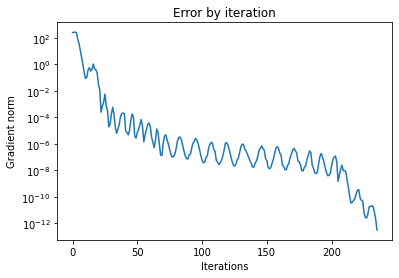

In [92]:
mp.xlabel( 'Iterations' )
mp.ylabel( 'Gradient norm' )
mp.title( 'Error by iteration' )
mp.yscale( 'log' )
mp.plot( S[5] )

### Using Polak-Ribière

In [93]:
iter = 1000
m = 5
eps = 1e-12
c1 = 0.001
c2 = 0.01
alpha = 0.1
x0 = np.array( [ 1.2, 1.2 ] )
t = 'pr'
S = non_lin_conj_grad_method( f, g, x0, t, eps, iter, alpha, c1, c2, m )
print( 'Optimal point:', S[0] )
print( 'Objective function value:', S[1] )
print( 'Gradient at optimal point:', S[2] )
print( 'Last descent direction:', S[3] )
print( 'Iterations:', S[4], '\n' )

Optimal point: [1. 1.]
Objective function value: 5.091801320362173e-27
Gradient at optimal point: [ 7.16315895e-13 -4.21884749e-13]
Last descent direction: [3.21756703e-13 3.16865345e-13]
Iterations: 289 



Plotting error in logarithmic scale, $\varepsilon_k = \|g_k\|, \forall k \in \mathbb{N}$

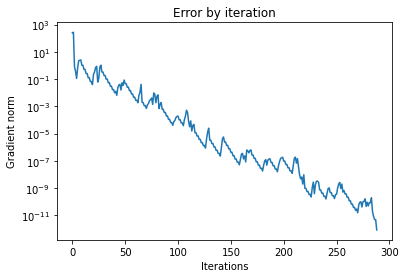

In [94]:
mp.xlabel( 'Iterations' )
mp.ylabel( 'Gradient norm' )
mp.title( 'Error by iteration' )
mp.yscale( 'log' )
mp.plot( S[5] )

### Using Hestenes-Stiefel

In [95]:
iter = 1000
m = 5
eps = 1e-12
c1 = 0.001
c2 = 0.01
alpha = 0.1
x0 = np.array( [ 1.2, 1.2 ] )
t = 'hs'
S = non_lin_conj_grad_method( f, g, x0, t, eps, iter, alpha, c1, c2, m )
print( 'Optimal point:', S[0] )
print( 'Objective function value:', S[1] )
print( 'Gradient at optimal point:', S[2] )
print( 'Last descent direction:', S[3] )
print( 'Iterations:', S[4], '\n' )

Optimal point: [1. 1.]
Objective function value: 2.821051522877166e-25
Gradient at optimal point: [-6.07291994e-13 -2.22044605e-13]
Last descent direction: [-4.51510584e-12 -9.38316082e-12]
Iterations: 55 



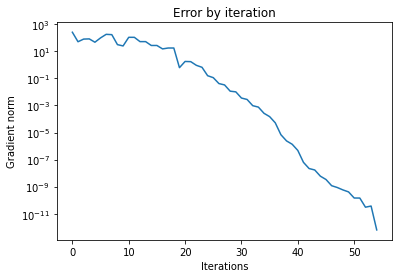

In [96]:
mp.xlabel( 'Iterations' )
mp.ylabel( 'Gradient norm' )
mp.title( 'Error by iteration' )
mp.yscale( 'log' )
mp.plot( S[5] )

### Using mix Fletcher-Reeves and Polak-Ribière

In [97]:
iter = 1000
m = 5
eps = 1e-12
c1 = 0.001
c2 = 0.01
alpha = 0.1
x0 = np.array( [ 1.2, 1.2 ] )
t = 'frpr'
S = non_lin_conj_grad_method( f, g, x0, t, eps, iter, alpha, c1, c2, m )
print( 'Optimal point:', S[0] )
print( 'Objective function value:', S[1] )
print( 'Gradient at optimal point:', S[2] )
print( 'Last descent direction:', S[3] )
print( 'Iterations:', S[4], '\n' )

Optimal point: [1. 1.]
Objective function value: 3.1891378422982997e-26
Gradient at optimal point: [ 4.13002965e-14 -1.99840144e-13]
Last descent direction: [-9.28016313e-15  1.79779153e-13]
Iterations: 119 



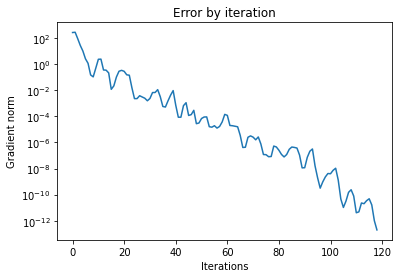

In [98]:
mp.xlabel( 'Iterations' )
mp.ylabel( 'Gradient norm' )
mp.title( 'Error by iteration' )
mp.yscale( 'log' )
mp.plot( S[5] )